## Calculating real scattering

Now that we have seen how `MDAnalysis` can be used to read the simulation trajectory. 
Lets use it to build a Debye equation function.
First, we need to know what values of $q$ that we want to consider, let's use the same values that are in the experimental data [1].
This experimental data set has over 1300 values of $q$ measured. 
In order to reduce the time taken, we will only consider every 10th data point.

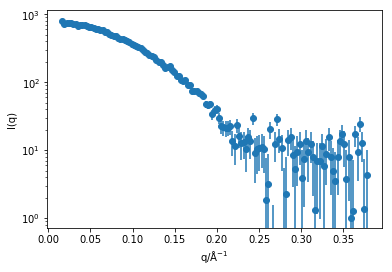

In [65]:
import numpy as np
import matplotlib.pyplot as plt

q, i, di = np.loadtxt('../assets/SASDA96.dat', unpack=True)
q *= 0.1
q = q[::10]
i = i[::10]
di = di[::10]
plt.errorbar(q, i, yerr=di, marker='o', ls='')
plt.xlabel('q/Å$^{-1}$')
plt.ylabel('I(q)')
plt.yscale('log')
plt.show()

This means there is now around 130 q values for which we need to calculate the Debye equation. 
To increase the efficiency of this, we will only calculate the distance between all of the atoms once.

In [3]:
import MDAnalysis as mda
import periodictable as pt
import scipy.constants as const
from MDAnalysis.analysis.distances import dist

cre = const.physical_constants['classical electron radius'][0] * 1e15

u = mda.Universe('../assets/lysozyme.pdb')

distances = []
for ts in u.trajectory:
    single_ts = []
    sl1 = []
    sl2 = [] 
    for i in range(0, len(u.atoms)-1):
        for j in range(i + 1, len(u.atoms)):
            sl1.append(np.multiply(pt.elements.symbol(
                u.atoms[i].type).xray.scattering_factors(energy=12)[0], cre))
            sl2.append(np.multiply(pt.elements.symbol(
                u.atoms[j].type).xray.scattering_factors(energy=12)[0], cre))
            single_ts.append(dist(mda.AtomGroup([u.atoms[i]]), mda.AtomGroup([u.atoms[j]]), box=ts.dimensions)[2][0])
    distances.append(single_ts)

We now have three lists, that contain the information of the distances between the atoms, and the elements associated with each distance. 
This means that we can use the code below to implement the Debye equation (note that in order to save some computational expense the Debye equation is slightly optimised using the `numpy` library). 

In [57]:
sim_i = np.zeros((6, q.size))
for k in range(len(distances)):
    for e, q_value in enumerate(q):
        sim_i[k][e] = np.sum(np.array(sl1) * np.array(sl2) * np.sin(
            np.array(distances[k]) * q_value) / (np.array(distances[k]) * q_value))

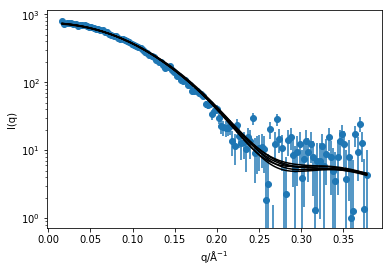

In [73]:
from scipy.optimize import curve_fit

def fit_f(x, a):
    return x * a

for k in range(len(distances)):
    s = curve_fit(fit_f, sim_i[k], i, sigma=di)
    plt.plot(q, sim_i[k] * s[0][0], 'k', zorder=10)
plt.errorbar(q, i, yerr=di, marker='o', ls='')
plt.xlabel('q/Å$^{-1}$')
plt.ylabel('I(q)')
plt.yscale('log')
plt.show()

As we can see, there is good agreement between the simulation and the experiment, with slight variation due to the thermal fluctucations of the protein in solution. 
Of course, as mentioned previously this is not a 'publication' quality method for comparing simulation and experiment, as this does not consider protein hydration, instrumental resolution effects, etc.
These effects are accounted for in software packages such as [CRYSOL](https://www.embl-hamburg.de/biosaxs/crysol.html) or [SASSIE](http://www.ccpsas.org/use.html) [2,3], which and read simulation trajectories and compare with experimental data.

## References

1. Frenke, D.; Jefferies, C. M.; Svergun, D. I. *Nat. Methods* 2015, **12**, 419–422. [10.1038/nmeth.3358](https://doi.org/10.1038/nmeth.3358).
2. Svergun D.I., Barberato C. and Koch M.H.J. *J. Appl. Crystallgr.* 1995, **28**, 768-773.[10.1107/S0021889895007047](https://doi.org/10.1107/S0021889895007047)
3. Perkins, S. J.; Wright, D. W.; Zhang, H.; et al. *J. Appl. Crystallogr.* 2016, **49** (6), 1861–1875. [10.1107/S160057671601517X](https://doi.org/10.1107/S160057671601517X).
